<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/7%20Model%20Selection%20%26%20Feature%20Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Selection**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for grid
!pip install geopy -q
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# CatBoost
!pip install catboost -q
from catboost import CatBoostRegressor, Pool
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
# RandomForest
from sklearn.ensemble import RandomForestRegressor
# Linear Regression+l1 Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
# LightGBM
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

!pip -qq install category_encoders
from category_encoders import TargetEncoder

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_5.xlsx', engine='openpyxl')

In [14]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments5.pkl -q

with open('apartments5.pkl', 'rb') as f:
    apartments = pickle.load(f)


Drop notinformative columns and make Encodin

In [17]:
apartments.drop(columns=['Host Since','First Review', 'Last Review','Reviews', 'Latitude_Bin', 'Longitude_Bin', 'Latitude_Bin2', 'Longitude_Bi2n','Listing ID'], inplace=True)

apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)

apartments['Host Response Time'] = apartments['Host Response Time'].replace(
    {'within an hour':0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3 }).fillna(3).astype(int)


In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

Value counts for column 'Listing ID' :
Listing ID
10002699    1
30934593    1
30947505    1
30946969    1
30946705    1
           ..
20716366    1
20716294    1
20710491    1
20710283    1
9996186     1
Name: count, Length: 19664, dtype: int64
NaN values: 0 


Value counts for column 'neighbourhood' :
neighbourhood
NeukÃ¶lln                3182
Prenzlauer Berg          2550
Kreuzberg                2509
Friedrichshain           2460
Mitte                    1749
Wedding                  1316
SchÃ¶neberg               935
Moabit                    715
Charlottenburg            696
Wilmersdorf               400
Pankow                    272
Rummelsburg               223
Tempelhof                 220
WeiÃensee                181
Lichtenberg               166
Alt-Treptow               156
Tiergarten                153
Steglitz                  135
Reinickendorf             133
Westend                    89
Lichterfelde               89
Friedenau                  77
Baumschulenweg        

# **Random forest**

## One-Hot Encoding

In [39]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns
for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Connecting pipelines for numeric and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# General pipeline: data preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_jobs=-1,
                              n_estimators = 300,
                              #max_depth = 12,
                              min_impurity_decrease = 0.05,
                              min_samples_split = 5,
                              max_features = 'sqrt',
                              random_state = 142
                              )
    )
])

# Model training
pipeline.fit(X_train, y_train)

# Prediction
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}", '\n')
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}", '\n')
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")


Train MSE: 476.966
Test MSE: 832.115
Train MAE: 15.477
Test MAE: 18.780
Train R^2: 0.718
Test R^2: 0.532 



## Target Encoding

In [41]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

for col in col_train_obj:
    X_train[col] = X_train[col].astype('category').cat.add_categories('abr@cadabra').fillna('abr@cadabra')
    # Change the data type to 'category' before using .cat accessor

for col in col_test_obj:
    X_test[col] = X_test[col].astype('category').cat.add_categories('abr@cadabra').fillna('abr@cadabra')
    # Change the data type to 'category' before using .cat accessor

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=15,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', RandomForestRegressor(n_jobs=-1,
                              n_estimators = 300,
                              #max_depth = 12,
                              min_impurity_decrease = 0.05,
                              min_samples_split = 5,
                              max_features = 'sqrt',
                              random_state = 142
                              ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}", '\n')
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}", '\n')
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")

Train MSE: 194.870
Test MSE: 764.541 

Train MAE: 9.927
Test MAE: 17.715 

Train R^2: 0.885
Test R^2: 0.570


                 Feature  Importance  Rating_Importance
13           Accomodates    0.115943                  1
5                Bin-Bin    0.108116                  2
4              Room Type    0.106085                  3
15              Bedrooms    0.096500                  4
16                  Beds    0.059120                  5
6              Bin2-Bin2    0.053492                  6
17       Guests Included    0.045745                  7
2            Postal Code    0.033173                  8
3          Property Type    0.031168                  9
35  Distance_from_center    0.029433                 10
31      Host Since Years    0.027013                 11
11             Longitude    0.024560                 12
14             Bathrooms    0.023855                 13
10              Latitude    0.022530                 14
32     Last Review Years    0.020103                 15
0          neighbourhood    0.019743                 16
30         Polarity_mean    0.019233            

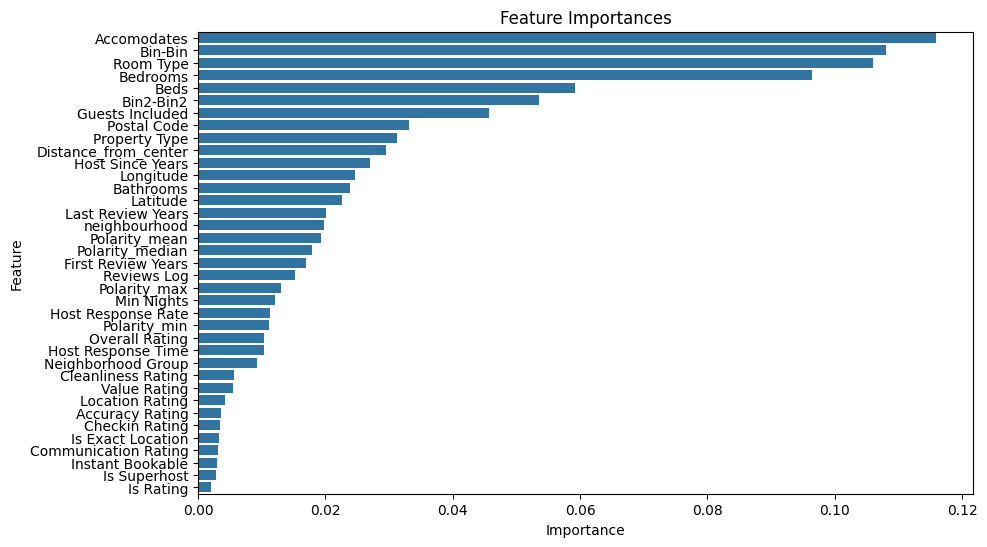

In [19]:
# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace('mean_target_encode__', '').str.replace('remainder__', '')
feature_importance_df['Rating_Importance'] = feature_importance_df['Importance'].rank(ascending=False).astype(int)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# **Lasso**

## One-Hot Encodind

In [43]:
# Division into features and targets
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)

# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Extraction of numerical and categorical features
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Numeric Data Pipeline: NaN Padding and Normalization
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for Categorical Data: One-Hot Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, max_iter=100000, random_state=142))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}", '\n')

# #для Price Log
# y_train_e = np.expm1(y_train)
# y_train_pred_e = np.expm1(y_train_pred)
# y_test_e = np.expm1(y_test)
# y_test_pred_e = np.expm1(y_test_pred)
# train_r2_e = r2_score(y_train_e, y_train_pred_e)
# test_r2_e = r2_score(y_test_e, y_test_pred_e)
# print(f"Train R^2 e: {train_r2_e:.3f}")
# print(f"Test R^2 e: {test_r2_e:.3f}")

# Важность признаков
model = pipeline.named_steps['model']
feature_names = (numerical_cols.tolist() +
                 pipeline.named_steps['preprocessor'].named_transformers_['cat']
                 .named_steps['onehot'].get_feature_names_out(categorical_cols).tolist())
importance = list(zip(feature_names, abs(model.coef_)))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, coef in importance_sorted:
    if coef != 0:
        print(f"{feature}: {coef:.3f}")

Train MSE: 0.151
Test MSE: 0.148
Train MAE: 0.299
Test MAE: 0.296
Train R^2: 0.534
Test R^2: 0.547 

Train R^2 e: 0.473
Test R^2 e: 0.475
Feature importance (sorted):
Room Type_Private room: 0.398
Accomodates: 0.142
neighbourhood_Mitte: 0.092
Bedrooms: 0.061
Distance_from_center: 0.057
Guests Included: 0.048
Cleanliness Rating: 0.041
Host Response Time: 0.040
Value Rating: 0.031
Last Review Years: 0.026
Neighborhood Group_NeukÃ¶lln: 0.024
Location Rating: 0.024
Min Nights: 0.023
Reviews Log: 0.022
Bathrooms: 0.021
Host Since Years: 0.016
Is Superhost: 0.010
Longitude: 0.009
Polarity_mean: 0.009
Is Rating: 0.009
Beds: 0.004


## Terget Encoding

In [44]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: Target Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder(min_samples_leaf=10,
                                     #smoothing=10,
                                     handle_missing='value',
                                     handle_unknown='value'

    ))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, max_iter=100000, random_state=142))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}", '\n')

# Важность признаков
model = pipeline.named_steps['model']
importance = list(zip(numerical_cols.tolist() + categorical_cols.tolist(), abs(model.coef_)))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, coef in importance_sorted:
    if coef != 0:
        print(f"{feature}: {coef:.3f}")


Train MSE: 707.329
Test MSE: 855.668
Train MAE: 17.948
Test MAE: 19.396
Train R^2: 0.582
Test R^2: 0.519
Feature importance (sorted):
Accomodates: 8.691
Bedrooms: 6.988
Reviews Log: 5.318
Guests Included: 4.192
Value Rating: 3.420
Distance_from_center: 3.179
Bathrooms: 2.896
Last Review Years: 2.750
Host Response Time: 2.360
Cleanliness Rating: 2.323
Min Nights: 1.992
Is Superhost: 1.503
Overall Rating: 1.482
First Review Years: 1.348
Longitude: 1.272
Latitude: 1.194
Polarity_mean: 1.098
Bin-Bin: 1.046
Host Since Years: 0.948
Property Type: 0.558
Host Response Rate: 0.496
Polarity_median: 0.474
Room Type: 0.457
Accuracy Rating: 0.385
Is Rating: 0.366
Location Rating: 0.170
Checkin Rating: 0.140
Communication Rating: 0.136
Beds: 0.136
Polarity_min: 0.130
Is Exact Location: 0.120
neighbourhood: 0.116
Neighborhood Group: 0.074
Postal Code: 0.069
Bin2-Bin2: 0.039
Instant Bookable: 0.020
Polarity_max: 0.003


                                   Feature  Importance
11                    remainder__Room Type  -19.072167
8                     remainder__Longitude  -14.717272
14                     remainder__Bedrooms   12.760017
13                    remainder__Bathrooms    9.972818
12                  remainder__Accomodates    6.638966
16              remainder__Guests Included    6.630135
29                remainder__Polarity_mean    5.000239
24                 remainder__Value Rating   -4.106765
10                remainder__Property Type   -4.016373
6                  remainder__Is Superhost    3.355687
5            remainder__Host Response Rate   -3.224562
33                  remainder__Reviews Log   -2.448124
20           remainder__Cleanliness Rating    2.254306
31            remainder__Last Review Years   -2.134414
4            remainder__Host Response Time   -1.887282
28              remainder__Polarity_median    1.844214
34         remainder__Distance_from_center   -1.117216
3         

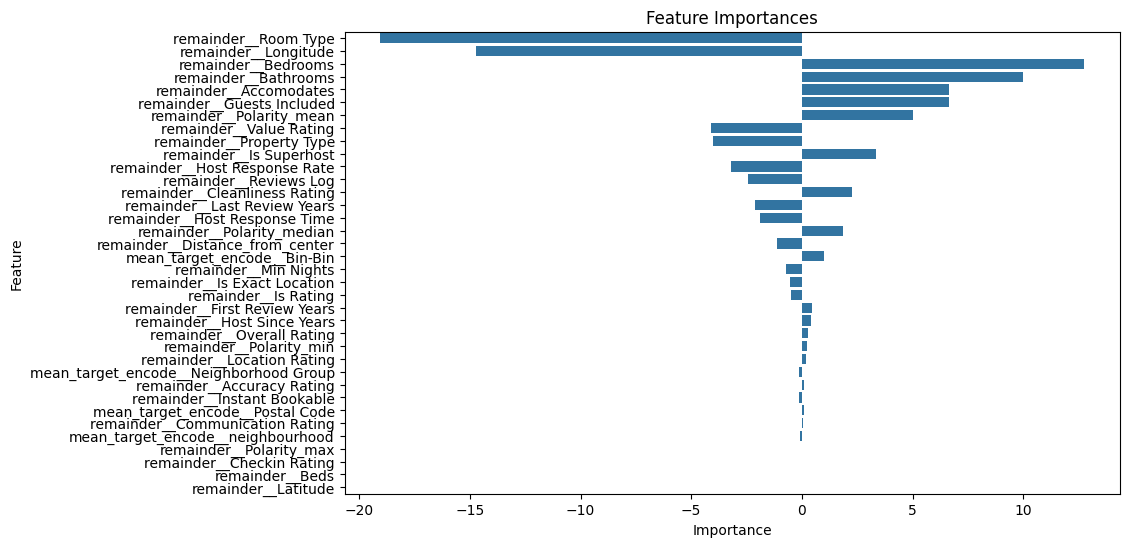

In [ ]:
# prompt: важность признаков для Lasso и график

# Get feature importances
importances = pipeline.named_steps['model'].coef_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', key = abs,  ascending=False)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# **XGBRegressor**

## One-Hot Encoding

In [38]:
# Разделение на фичи и таргет
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)


# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: One-Hot инкодинг
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore' ))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=200,
                           learning_rate=0.05,
                           colsample_bylevel = 0.3, # доля признаков
                           max_depth = 6, # максимальная глубина
                           gamma = 0.1,

                           random_state=142)
    )
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")

# Важность признаков
model = pipeline.named_steps['model']
importance = list(zip(numerical_cols.tolist() +
                      pipeline.named_steps['preprocessor'].named_transformers_['cat']
                      .named_steps['onehot'].get_feature_names_out(categorical_cols).tolist(),
                      model.feature_importances_))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, importance in importance_sorted:
    if importance != 0:
        print(f"{feature}: {importance:.3f}")


Train MSE: 472.165
Test MSE: 713.559
Train MAE: 14.919
Test MAE: 17.156
Train R^2: 0.721
Test R^2: 0.599
Feature importance (sorted):
Room Type_Private room: 0.056
Bedrooms: 0.039
Accomodates: 0.031
Beds: 0.024
Bathrooms: 0.022
neighbourhood_Mitte: 0.016
Property Type_Hotel: 0.015
Bin2-Bin2_44-28: 0.014
Guests Included: 0.013
Property Type_Boutique hotel: 0.011
neighbourhood_NeukÃ¶lln: 0.010
Bin2-Bin2_49-38: 0.009
Property Type_Hostel: 0.009
Postal Code_10963.0: 0.007
Bin-Bin_83-73: 0.006
Bin-Bin_89-51: 0.006
neighbourhood_Kreuzberg: 0.005
Postal Code_10117.0: 0.005
Property Type_Loft: 0.005
Distance_from_center: 0.005
Postal Code_10249.0: 0.005
Bin2-Bin2_47-31: 0.005
Bin-Bin_86-54: 0.004
Neighborhood Group_NeukÃ¶lln: 0.004
Neighborhood Group_Tempelhof - SchÃ¶neberg: 0.004
Postal Code_12101.0: 0.004
Bin2-Bin2_55-34: 0.004
Bin-Bin_102-73: 0.004
Bin2-Bin2_34-23: 0.004
Bin2-Bin2_47-41: 0.004
neighbourhood_Wedding: 0.004
Bin2-Bin2_Other: 0.004
Host Response Time: 0.004
Bin2-Bin2_37-35: 0.0

## Terget Encoding

In [45]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: Target Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder(min_samples_leaf=10,
                                     #smoothing=10,
                                     handle_missing='value',
                                     handle_unknown='value'

    ))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=200,
                           learning_rate=0.05,
                           colsample_bylevel = 0.3, # доля признаков
                           max_depth = 6, # максимальная глубина
                           gamma = 0.1,

                           random_state=142)
     )
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}", '\n')

Train MSE: 378.207
Test MSE: 748.570
Train MAE: 13.205
Test MAE: 17.393
Train R^2: 0.776
Test R^2: 0.579 



AttributeError: Coefficients are not defined for Booster type None

# CatBoost
for CatBost no nessery to make encoding and Nan

In [25]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# !pip install catboost -q
# from catboost import CatBoostRegressor, Pool  # Now CatBoost is available

X = apartments.drop(['Price', 'Price Log'], axis=1)
y = apartments['Price']

num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(exclude='number').columns

for col in cat_features:
    if X[col].dtype != 'str':
        X[col] = X[col].astype(str)

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Convert cat_features to a list
cat_features = cat_features.tolist()  # This is the key change

# Создаем модели для обучающей и тестовой выборок с указанием категориальных признаков
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Инициализируем и обучаем модель
model = CatBoostRegressor(iterations=2000, learning_rate=0.02, depth=6, verbose=100)
model.fit(train_pool)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики для обучающей выборки
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Вычисляем метрики для тестовой выборки
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Выводим метрики на обучающей выборке
print("Metrics on Training Set:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R^2 Score: {train_r2}")

# Выводим метрики на тестовой выборке
print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R^2 Score: {test_r2}")


# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature_name, importance in feature_importance_tuples:
    print(f'Feature: {feature_name}, Importance: {importance}')


0:	learn: 40.9356594	total: 73.6ms	remaining: 2m 27s
100:	learn: 28.5038708	total: 6.53s	remaining: 2m 2s
200:	learn: 26.8380673	total: 9.6s	remaining: 1m 25s
300:	learn: 26.0931179	total: 14.6s	remaining: 1m 22s
400:	learn: 25.6131754	total: 17.3s	remaining: 1m 8s
500:	learn: 25.2311047	total: 20s	remaining: 60s
600:	learn: 24.8478504	total: 22.8s	remaining: 53.1s
700:	learn: 24.5494568	total: 27.5s	remaining: 50.9s
800:	learn: 24.3135383	total: 30.2s	remaining: 45.1s
900:	learn: 24.0742430	total: 32.8s	remaining: 40s
1000:	learn: 23.8700103	total: 35.5s	remaining: 35.4s
1100:	learn: 23.6996675	total: 39.7s	remaining: 32.4s
1200:	learn: 23.5278115	total: 42.7s	remaining: 28.4s
1300:	learn: 23.3624463	total: 45.4s	remaining: 24.4s
1400:	learn: 23.1900796	total: 48.1s	remaining: 20.5s
1500:	learn: 23.0402748	total: 51.2s	remaining: 17s
1600:	learn: 22.8896515	total: 55.3s	remaining: 13.8s
1700:	learn: 22.7643253	total: 57.9s	remaining: 10.2s
1800:	learn: 22.6278216	total: 1m	remaining: 

                 Feature  Importance
0               Bedrooms   17.180767
1                   Beds   12.227923
2             Min Nights    9.751448
3        Accuracy Rating    5.518591
4        Guests Included    5.387773
5      Is Exact Location    4.700181
6               Latitude    3.706029
7            Postal Code    3.627380
8            Reviews Log    3.232755
9   Distance_from_center    3.136845
10             Room Type    3.003701
11             Is Rating    2.952272
12    Host Response Rate    2.277755
13         Property Type    2.198542
14    Cleanliness Rating    2.071636
15          Polarity_max    1.941269
16     Last Review Years    1.862327
17    Neighborhood Group    1.771079
18    First Review Years    1.750317
19        Overall Rating    1.671663
20        Checkin Rating    1.516250
21    Host Response Time    1.464679
22             Longitude    1.405100
23       Location Rating    1.108810
24      Host Since Years    1.042825
25         neighbourhood    0.934234
2

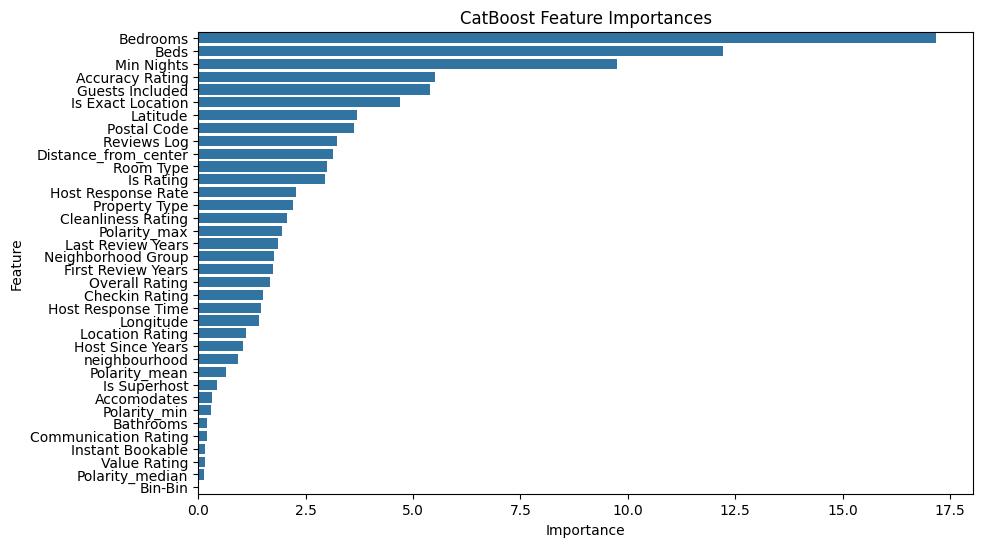

In [ ]:
# prompt: важность признаков для CatBoostRegressor и добавь график вроде # Print or plot the feature importances

# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame(feature_importance_tuples, columns=['Feature', 'Importance'])

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('CatBoost Feature Importances')
plt.show()


# LightGBM
for CatBost no nessery to make encoding and Nan

In [26]:
X = apartments.drop(['Price', 'Price Log'], axis=1)
y = apartments['Price']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to 'category' dtype
for feature in categorical_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

# Инициализируем и обучаем модель
model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train, categorical_feature=categorical_features)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(X_train) # Use X_train instead of train_pool
y_test_pred = model.predict(X_test) # Use X_test instead of test_pool

# Вычисляем метрики для обучающей выборки
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Вычисляем метрики для тестовой выборки
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Выводим метрики на обучающей выборке
print("Metrics on Training Set:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R^2 Score: {train_r2}")

# Выводим метрики на тестовой выборке
print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R^2 Score: {test_r2}")


# Важность признаков
importance = model.feature_importances_
feature_names = X_train.columns

# Вывод важности признаков в порядке убывания
importance_dict = dict(zip(feature_names, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5314
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 37
[LightGBM] [Info] Start training from score 59.493350
Metrics on Training Set:
Mean Squared Error: 374.22841941534193
Mean Absolute Error: 13.32216331202647
R^2 Score: 0.7805602909055841

Metrics on Test Set:
Mean Squared Error: 729.4663726449057
Mean Absolute Error: 17.55578426828168
R^2 Score: 0.5769264316697624

Feature importance 

# XGBRegressor

## TargetEncoder

In [ ]:
X = apartments.drop(columns=['Price'])
y = apartments['Price']

X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 100].index
    X[col] = X[col].replace(rare_categories, 'Other')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

# X_train[col_train_obj] = X_train[col_train_obj].fillna('abr@cadabra')
# X_test[col_test_obj] = X_test[col_test_obj].fillna('abr@cadabra')

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=10,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', xgb.XGBRegressor(
                        n_estimators=1000,
                        learning_rate=0.02,
                        max_depth=5,
                        verbosity=1))
])


# Определим eval_set для контроля обучения
# eval_set = [(X_train, y_train), (X_test, y_test)]

# # Обучим модель с выводом RMSE на каждой итерации, убираем evals_result
# model.fit(X_train, y_train, eval_set=eval_set, verbose=True)



pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))

Train RMSE: 19.33788815243981
Test RMSE: 25.701568928114934
R²: 0.5548773243289163
Train MAE: 13.108293085739062
Test MAE: 16.381663037534587


## LabelEncoder

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = apartments

# Выделяем категориальные признаки
categorical_features = df.select_dtypes(exclude='number').columns


# Закодируем категориальные переменные
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# Разделим признаки и целевую переменную
X = df.drop('Price', axis=1)
y = df['Price']

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Создадим объект модели
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=5, verbosity=1)


# Определим eval_set для контроля обучения
eval_set = [(X_train, y_train), (X_test, y_test)]

# Обучим модель с выводом RMSE на каждой итерации, убираем evals_result
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# # Обучим модель
# model.fit(X_train, y_train)

# Предсказания на тренировочной и тестовой выборках
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Вывод метрик
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

print("Training R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")


[0]	validation_0-rmse:38.27791	validation_1-rmse:38.16144
[1]	validation_0-rmse:37.88844	validation_1-rmse:37.81285
[2]	validation_0-rmse:37.51121	validation_1-rmse:37.47468
[3]	validation_0-rmse:37.14252	validation_1-rmse:37.14792
[4]	validation_0-rmse:36.78529	validation_1-rmse:36.82569
[5]	validation_0-rmse:36.43752	validation_1-rmse:36.51623
[6]	validation_0-rmse:36.10019	validation_1-rmse:36.21411
[7]	validation_0-rmse:35.76915	validation_1-rmse:35.92328
[8]	validation_0-rmse:35.45046	validation_1-rmse:35.64109
[9]	validation_0-rmse:35.13937	validation_1-rmse:35.37170
[10]	validation_0-rmse:34.83896	validation_1-rmse:35.10552
[11]	validation_0-rmse:34.54370	validation_1-rmse:34.85131
[12]	validation_0-rmse:34.26062	validation_1-rmse:34.60561
[13]	validation_0-rmse:33.98433	validation_1-rmse:34.36302
[14]	validation_0-rmse:33.71390	validation_1-rmse:34.13676
[15]	validation_0-rmse:33.45310	validation_1-rmse:33.90580
[16]	validation_0-rmse:33.19839	validation_1-rmse:33.69250
[17]	va


Feature importance in descending order:
Host Since Years: 1822.0
Postal Code: 1681.0
Accomodates: 1575.0
Longitude: 1567.0
First Review Years: 1497.0
Distance_from_center: 1458.0
Last Review Years: 1404.0
Latitude: 1161.0
Bin-Bin: 1072.0
Polarity_mean: 927.0
Host Response Rate: 898.0
Polarity_median: 895.0
neighbourhood: 820.0
Bedrooms: 784.0
Guests Included: 750.0
Reviews Log: 717.0
Polarity_max: 715.0
Overall Rating: 655.0
Min Nights: 628.0
Beds: 547.0
Room Type: 532.0
Polarity_min: 519.0
Host Response Time: 476.0
Neighborhood Group: 412.0
Value Rating: 410.0
Cleanliness Rating: 352.0
Bathrooms: 303.0
Checkin Rating: 293.0
Communication Rating: 147.0
Is Superhost: 144.0
Property Type: 134.0
Instant Bookable: 119.0
Is Exact Location: 116.0
Location Rating: 96.0
Accuracy Rating: 92.0


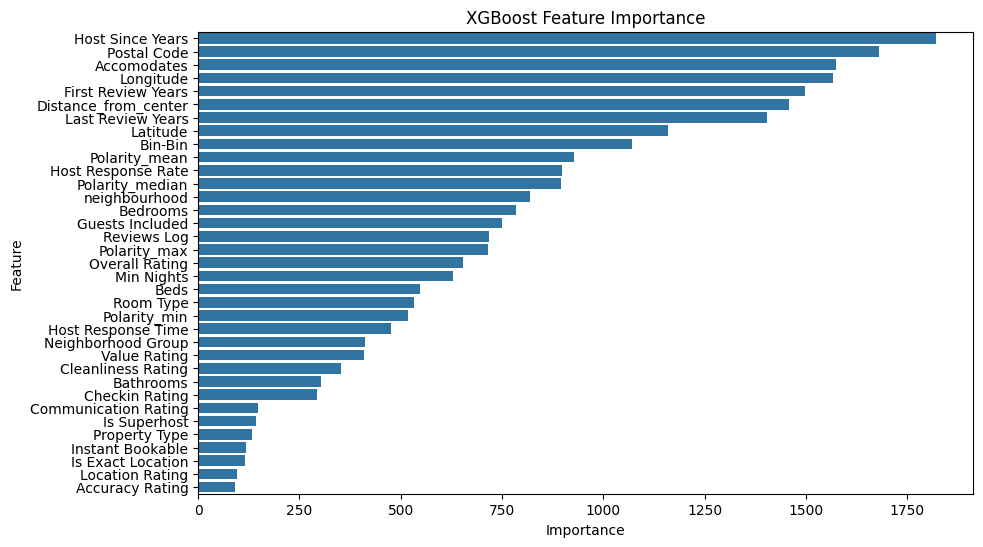

In [ ]:
# prompt: важность признаков для XGBoostRegressor и добавь график

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

# Создание DataFrame для визуализации
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance')
plt.show()


# Encoding

Converting categorical data to numerical

In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

In [ ]:
# Perform one-hot encoding and drop the first column
neighborhood_dummies = pd.get_dummies(apartments['Neighborhood Group'], prefix='Neighborhood', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
apartments = pd.concat([apartments, neighborhood_dummies], axis=1)

In [ ]:
numeric_columns = apartments.select_dtypes(include=['number']).columns

print(numeric_columns)

Index(['Host Response Time', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Is Exact Location', 'Property Type', 'Room Type',
       'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating',
       'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating',
       'Communication Rating', 'Location Rating', 'Value Rating',
       'Instant Bookable', 'Polarity_min', 'Polarity_max', 'Polarity_median',
       'Polarity_mean', 'Host Since Years', 'Last Review Years',
       'First Review Years', 'Latitude_Bin', 'Longitude_Bin', 'Price Log',
       'Reviews Log', 'Distance_from_center'],
      dtype='object')


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

numeric_columns = numeric_columns.drop(['Price Log'])

df = apartments[numeric_columns].copy()

# Предположим, что df - ваш датафрейм
X = df.drop('Price', axis=1)
y = df['Price']

# Создаем модель Лассо
model = Lasso(alpha=0.1)  # Параметр alpha регулирует степень регуляризации
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

print(f"\n Lasso")
print(f"R^2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


# Важность признаков
feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print("Feature importance using Lasso:")
print(feature_importance)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#apartments.to_excel('apartments_6.xlsx', index=False)

# import pickle
with open('apartments6.pkl', 'wb') as f:
    pickle.dump(apartments, f)


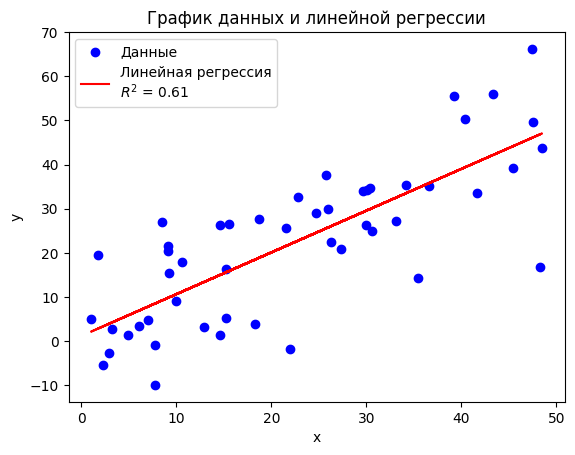

0.6070779632772065

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Случайные данные с известным R^2
np.random.seed(42)
x = np.random.rand(50, 1) * 50  # переменная x в диапазоне от 0 до 10
y = x + np.random.normal(0, 12, size=(50, 1))  # линейная зависимость с добавлением шума

# Модель линейной регрессии
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Подсчет R^2
r2 = r2_score(y, y_pred)


# Построение графика
plt.scatter(x, y, color='blue', label='Данные')
plt.plot(x, y_pred, color='red', label=f'Линейная регрессия\n$R^2$ = {r2:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('График данных и линейной регрессии')
plt.legend()
plt.show()

r2